In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) { return false; }

<IPython.core.display.Javascript object>

In [11]:
import matplotlib
#matplotlib.use("Agg")
%matplotlib inline

In [12]:

import math
def transform(m, v):
    return np.asarray(m * np.asmatrix(v).T)[:,0]
 
def magnitude(v):
    return math.sqrt(np.sum(v ** 2))
 
def normalize(v):
    m = magnitude(v)
    if m == 0:
        return v
    return v / m
 
def ortho(l, r, b, t, n, f):
    dx = r - l
    dy = t - b
    dz = f - n
    rx = -(r + l) / (r - l)
    ry = -(t + b) / (t - b)
    rz = -(f + n) / (f - n)
    return np.matrix([[2.0/dx,0,0,rx],
                      [0,2.0/dy,0,ry],
                      [0,0,-2.0/dz,rz],
                      [0,0,0,1]])
 
def perspective(fovy, aspect, n, f):
    s = 1.0/math.tan(math.radians(fovy)/2.0)
    sx, sy = s / aspect, s
    zz = (f+n)/(n-f)
    zw = 2*f*n/(n-f)
    return np.matrix([[sx,0,0,0],
                      [0,sy,0,0],
                      [0,0,zz,zw],
                      [0,0,-1,0]])
 
def frustum(x0, x1, y0, y1, z0, z1):
    a = (x1+x0)/(x1-x0)
    b = (y1+y0)/(y1-y0)
    c = -(z1+z0)/(z1-z0)
    d = -2*z1*z0/(z1-z0)
    sx = 2*z0/(x1-x0)
    sy = 2*z0/(y1-y0)
    return np.matrix([[sx, 0, a, 0],
                      [ 0,sy, b, 0],
                      [ 0, 0, c, d],
                      [ 0, 0,-1, 0]])
 
def translate(xyz):
    x, y, z = xyz
    return np.matrix([[1,0,0,x],
                      [0,1,0,y],
                      [0,0,1,z],
                      [0,0,0,1]])
 
def scale(xyz):
    x, y, z = xyz
    return np.matrix([[x,0,0,0],
                      [0,y,0,0],
                      [0,0,z,0],
                      [0,0,0,1]])
 
def sincos(a):
    a = math.radians(a)
    return math.sin(a), math.cos(a)
 
def rotate(a, xyz):
    x, y, z = normalize(xyz)
    s, c = sincos(a)
    nc = 1 - c
    return np.matrix([[x*x*nc +   c, x*y*nc - z*s, x*z*nc + y*s, 0],
                      [y*x*nc + z*s, y*y*nc +   c, y*z*nc - x*s, 0],
                      [x*z*nc - y*s, y*z*nc + x*s, z*z*nc +   c, 0],
                      [           0,            0,            0, 1]])
 
def rotx(a):
    s, c = sincos(a)
    return np.matrix([[1,0,0,0],
                      [0,c,-s,0],
                      [0,s,c,0],
                      [0,0,0,1]])
 
def roty(a):
    s, c = sincos(a)
    return np.matrix([[c,0,s,0],
                      [0,1,0,0],
                      [-s,0,c,0],
                      [0,0,0,1]])
 
def rotz(a):
    s, c = sincos(a)
    return np.matrix([[c,-s,0,0],
                      [s,c,0,0],
                      [0,0,1,0],
                      [0,0,0,1]])
 
def lookat(eye, target, up):
    F = target[:3] - eye[:3]
    f = normalize(F)
    U = normalize(up[:3])
    s = np.cross(f, U)
    u = np.cross(s, f)
    M = np.matrix(np.identity(4))
    M[:3,:3] = np.vstack([s,u,-f])
    T = translate(-eye)
    return np.dot(M, T)
 
def viewport(x, y, w, h):
    x, y, w, h = map(float, (x, y, w, h))
    return np.matrix([[w/2, 0  , 0,x+w/2],
                      [0  , h/2, 0,y+h/2],
                      [0  , 0  , 1,    0],
                      [0  , 0  , 0,    1]])

In [43]:
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import imageio
import bisect
    
class Frame(dict):
    _simple=True
    def __getattr__(self, name):
        if name in self:
            return self[name]
        else:
            raise AttributeError("No such attribute: " + name)
    def __setattr__(self, name, value):
        self[name] = value

    def __delattr__(self, name):
        if name in self:
            del self[name]
        else:
            raise AttributeError("No such attribute: " + name)
    def translate(self, translation):
         raise AttributeError("Not implemented")
    def rotate(self, rotation):
        raise AttributeError("Not implemented")
    def clone(self, rotation):
        raise AttributeError("Not implemented")
def linear(a,b,t):
    #print('a',a,'b',b,'t',t)
    return np.array(a)*(1.-t)+np.array(b)*t
            
class FrameSet(dict):
    def __iter__(self):
        #print(self.keys())
        return iter(sorted(self.keys()))
    def between(self, t, keys=None):
        last_t=None
        last_f=None
        myt = None
        for myt in self:
            #print('myt=',myt,'t=',t)
            f=self[myt]
            if keys is not None and len([key in f for key in keys])<len(keys):
                #print('key',keys, 'f keys:',f.keys, 'inter', [key in f for key in keys])
                continue
            if t>=myt:
                #print('t<myt')
                last_t=myt
                last_f=f
            else:
                #print('t>myt')
                break
        if myt is not None and last_t is not None:
            return Frame(ft=(t-last_t)/(myt-last_t),f0=last_f,f1=f) 
        elif myt is None and last_t is not None:
            return Frame(ft=1.,f0=last_f,f1=f) 
        elif myt is not None and last_t is None:
            return Frame(ft=0.,f0=last_f,f1=f) 
    def interpolate(self, t):
        raise Exception("not implemented")
    def f_between(self,f,t,key):
        s = self.between(t,keys=[key])
        if s.f1 is None and s.f0 is None:
            raise Exception("no.")
        if s.f1 is None: return s.f0[key]
        if s.f0 is None: return s.f1[key]
        #return s.f0[key]
        return f(s.f0[key],s.f1[key], s.ft)
    def linear_between(self,t,key):
        return self.f_between(linear,t,key)
 
    

class CameraFrameSet(FrameSet):
    def interpolate(self, time):
        f = Frame(
                  
                  #position = np.array(self.linear_between(time,'position' )),
                  look_at =  np.array(self.linear_between(time,'look_at' )),
                  #side =  np.array(self.linear_between(time,'side' )),
                  #area = self.linear_between(time,'area' )
                    axis = self.axis,
              )
        #print('position', f.position)
        print('lookat', f.look_at)
        
        #f.matrix = lookat(f.position, f.look_at, np.array([0.,1.,0.]))
        #print('matrix', f.matrix)
        return f 
    def look(self,  framset, time):
         
        camera_now = self.interpolate(time)
        actor_now = framset.interpolate(time)
        actor_now.translate(-camera_now.look_at)
        actor_now.swap(camera_now.axis)
        #actor_now.transform(camera_now.matrix)
        #actor_now.translate(camera_now.translation)
        #actor_now.rotate(camera_now.rotation)
        #if camera_now.area:
        #    actor_now.cut(camera_now.area)
        
        return actor_now
    
class GadgetFrame(Frame):
    def __init__(self, *l, **dataset):
        #print('keys',dataset.keys())
        super(self.__class__, self).__init__(*l, **dataset)
        
    def translate(self, translation):
        for ptype in self:
            if(len(self[ptype]["POS "])>0):
                self[ptype]["POS "] += translation 
    def swap(self, axis):
        for ptype in self:
            if(len(self[ptype]["POS "])>0):
                a = self[ptype]["POS "][:,(axis+1)%3]
                b = self[ptype]["POS "][:,(axis+2)%3]
                self[ptype]["POS "][:,0] = a
                self[ptype]["POS "][:,1] = b
                #print('new axes',axis, (axis+1)%3,(axis+2)%3 )
    def transform(self, matrix):
        for ptype in self:
            print("primta",self[ptype]["POS "].shape,matrix,matrix[0,3],matrix[1,3],matrix[2,3],self[ptype]["POS "][0:10])
            n =  np.dot(self[ptype]["POS "] , matrix[0:3,0:3])
            print("dopto1",n[0:10],np.dot(self[ptype]["POS "][0] , matrix[0:3,0:3]))
            self[ptype]["POS "][:,0] = n[:,0].flatten()+matrix[0,3]
            self[ptype]["POS "][:,1] = n[:,1].flatten()+matrix[1,3]
            self[ptype]["POS "][:,2] = n[:,2].flatten()+matrix[2,3]
            print("dopto",self[ptype]["POS "].shape,self[ptype]["POS "][0:10])
    def cut(self, area):
        
        for pt in self:
            mask = (
                (np.abs(self[pt]["POS "][:,0])<area) & 
                (np.abs(self[pt]["POS "][:,1])<area) & 
                (np.abs(self[pt]["POS "][:,2])<area)  
            )
            for key in self[pt]:
                self[pt][key] = self[pt][key][mask]
    
    def rotate(self, rotation):
        for ptype in self:
            self[ptype]["POS "] = np.dot(self[ptype]["POS "] , rotation)
    def add_to_axis(self, pt, ax):
        data=self
        colors=['orange','gray',None,None,'lightblue','yellow']
        marked_colors=['red','black',None,None,'blue','pink']
        # print(data[pt]["POS "][:,0].shape,data[pt]["POS "][:,0])
        #print(data[pt]["POS "][:,1].shape,data[pt]["POS "][:,1])
        ax.scatter(data[pt]["POS "][:,0], data[pt]["POS "][:,1], s=1, marker='.', c=colors[pt])
        if 'MARK' in data[pt]:
            ax.scatter(data[pt]["POS "][:,0][data[pt]['MARK']],
                        data[pt]["POS "][:,1][data[pt]['MARK']],
                        s=1,
                        marker='x',
                        c=marked_colors[pt]
                      )
                        
    def to_pyplot(self, ax):
        data = self
        self.add_to_axis(1, ax)
        self.add_to_axis(0, ax)
        self.add_to_axis(4, ax)
class GadgetFrameSet(FrameSet):
    def interpolate(self, time):
        fs =self.between(time)
        
        data =GadgetFrame()
        #print(fs.f0)
        for ptype in fs.f0:
            data[ptype] = {}
            
            
            
            
            mask0_common_ids = np.in1d(fs.f0[ptype]["ID  "],fs.f1[ptype]["ID  "])
            mask1_common_ids = np.in1d(fs.f1[ptype]["ID  "],fs.f0[ptype]["ID  "])
            
            data[ptype]["POS "] = np.copy(fs.f0[ptype]["POS "])
            if(len(data[ptype]["POS "])>0 
               and len(data[ptype]["POS "][mask0_common_ids])>0 
               and len(fs.f1[ptype]["POS "][mask1_common_ids]) ):
                data[ptype]["POS "][mask0_common_ids] = (
                    fs.f0[ptype]["POS "][mask0_common_ids]*(1.-fs.ft)+
                    fs.f1[ptype]["POS "][mask1_common_ids]*fs.ft
                )
            data[ptype]["MASS"] = fs.f0[ptype]["MASS"]
            data[ptype]["MARK"] = np.in1d(fs.f0[ptype]["ID  "],self.track_ids)
            #print('ids = ',len(data[ptype]["MARK"][data[ptype]["MARK"]]))
        return data 
    
class GUI(object):
    def __init__(self, scene):
        self.scene = scene
    def matplotlib_3cameras_movie(me,  deltat, filename):
        self = me.scene
        images = []
        t0 = sorted(self.dataset.keys())[0]
        t1 = sorted(self.dataset.keys())[-1]
        interval = t1-t0
        n_frames = int(interval/deltat)
        print(t0,t1,interval,deltat,n_frames)
        for i_frame in range(n_frames):
            actors=[]
            time = t0+deltat*i_frame
            print('t=',time)
            n_cameras = len(self.cameras)
            fig, axes = plt.subplots(1, n_cameras, figsize=(10,5))
            fig.suptitle('a=%.1f'%(time))
            fig.tight_layout()
            fig.subplots_adjust(wspace=0, hspace=0)
            for i_camera in range(n_cameras):
                axes[i_camera].set_aspect('equal')
                axes[i_camera].set_xlim([-1300.,1300.])
                axes[i_camera].set_ylim([-1300.,1300.])
                self.cameras[i_camera].look(self.dataset,time).to_pyplot(axes[i_camera])
                
            fig.canvas.draw()       # draw the canvas, cache the renderer
            image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
            image  = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
            images.append(image)
        imageio.mimsave(filename, images, fps=1)

        
class GadgetScene(object):
    dataset = None
    cameras = []
    def __init__(self, snap_base, snaps_data, radius,track=None, set_dataset =True, set_cameras=True):
  
        self.set(  snap_base, snaps_data, radius,track=track, set_dataset =set_dataset, set_cameras=set_cameras)
    def set(self, snap_base, snaps_data, radius,track=None, set_dataset =True, set_cameras=True):
        import g3read
        if set_dataset:
            self.dataset =  GadgetFrameSet()
        if set_cameras: 
            self.cameras=[CameraFrameSet( ),CameraFrameSet( ),CameraFrameSet( )]
            for i in range(3):
                self.cameras[i].axis=i
        for snap_data in snaps_data:
             
             
            
            if not snap_data.snapshot:
                continue
            snapshot = snap_data.snapshot
           
            snapshot_file = snap_base%(snapshot, snapshot)
            if not (os.path.exists(snapshot_file+'.0')):
                continue
            print('reading %s'%(snapshot_file))
            time = 1./(1.+g3read.GadgetFile(snapshot_file+'.0').header.redshift)
            if set_dataset:
                """
                ini={1:{
                        "MASS":np.arange(6),
                        "ID  ":np.arange(6),
                        "POS ":np.array([
                             [snap_data.center[0]-snap_data.radius, snap_data.center[1], snap_data.center[2]],
                             [snap_data.center[0]+snap_data.radius, snap_data.center[1], snap_data.center[2]],
                             [snap_data.center[0], snap_data.center[1]-snap_data.radius, snap_data.center[2]],
                             [snap_data.center[0], snap_data.center[1]+snap_data.radius, snap_data.center[2]],
                             [snap_data.center[0], snap_data.center[1], snap_data.center[2]-snap_data.radius],
                             [snap_data.center[0], snap_data.center[1], snap_data.center[2]+snap_data.radius]
                            
                            
                        ])
                    }
                }
                ini[-1]=ini[1]
                """
                ini = g3read. read_particles_in_box(snapshot_file,
                                                    snap_data.center,
                                                    snap_data.radius,["MASS","POS ","ID  "],
                                                    [0,1,4,5],
                                                    join_ptypes=False,
                                                    only_joined_ptypes=False)
     

                if track is not None:
                    for ptype in ini:
                        f_oder_by_ids =  np.argsort(ini[ptype]["ID  "])
                        for key in ini[ptype]:
                            ini[ptype][key] = ini[ptype][key][f_oder_by_ids]
                #print(ini)
                self.dataset[time] =   GadgetFrame(ini            )
            if set_cameras:
                """
                self.cameras[0][time] = Frame(position =  [snap_data.center[0], snap_data.center[1], snap_data.center[2]-snap_data.radius],
                                          look_at = snap_data.center,
                                          side = [0,1,0], area=200)
                self.cameras[1][time] = Frame(position = [snap_data.center[0]+snap_data.radius, snap_data.center[1], snap_data.center[2]],
                                          look_at = snap_data.center,
                                          side = [0,1,0], area=200)
                self.cameras[2][time] = Frame(position = [snap_data.center[0], snap_data.center[1]-snap_data.radius, snap_data.center[2]],
                                          look_at = snap_data.center,
                                          side = [0,1,0], area=200)
                """
                self.cameras[0][time] = Frame (look_at = snap_data.center,axis=2, area=200)
                self.cameras[1][time] = Frame(look_at = snap_data.center,axis=0, area=200)
                self.cameras[2][time] = Frame(look_at = snap_data.center,axis=1, area=200)

        if track is not None and set_dataset:
            self.dataset.track_ids = np.sort(np.concatenate(
                (
                    self.dataset[time][0]["ID  "][
                        (self.dataset[time][0]["POS "][:,0]-snap_data.center[0])**2.+
                        (self.dataset[time][0]["POS "][:,1]-snap_data.center[1])**2.+
                        (self.dataset[time][0]["POS "][:,2]-snap_data.center[2])**2.< 50.**2.
                    ],
            self.dataset[time][1]["ID  "][
                        (self.dataset[time][1]["POS "][:,0]-snap_data.center[0])**2.+
                        (self.dataset[time][1]["POS "][:,1]-snap_data.center[1])**2.+
                        (self.dataset[time][1]["POS "][:,2]-snap_data.center[2])**2.< 50.**2.
                    ],
              self.dataset[time][4]["ID  "][
                        (self.dataset[time][4]["POS "][:,0]-snap_data.center[0])**2.+
                        (self.dataset[time][4]["POS "][:,1]-snap_data.center[1])**2.+
                        (self.dataset[time][4]["POS "][:,2]-snap_data.center[2])**2.< 50.**2.
                    ] )
            )
                                            )



In [46]:
import g3read
snap_base = '/HydroSims/Magneticum/Box4/uhr_test/snapdir_%03d/snap_%03d'

                

snaps_data = [Frame(time=bucket.a, snapshot=int(bucket.snap_base[-3:]), center=bucket.gpos(), radius=500.) for bucket in buckets if bucket.can_read()]
#snaps_data
key_frames = GadgetScene(snap_base, snaps_data,2000., track='final')
#key_frames.set(snap_base, snaps_data,2000., track='final', set_dataset= False)

reading /HydroSims/Magneticum/Box4/uhr_test/snapdir_012/snap_012
reading /HydroSims/Magneticum/Box4/uhr_test/snapdir_016/snap_016
reading /HydroSims/Magneticum/Box4/uhr_test/snapdir_020/snap_020
reading /HydroSims/Magneticum/Box4/uhr_test/snapdir_024/snap_024
reading /HydroSims/Magneticum/Box4/uhr_test/snapdir_028/snap_028
reading /HydroSims/Magneticum/Box4/uhr_test/snapdir_032/snap_032
reading /HydroSims/Magneticum/Box4/uhr_test/snapdir_036/snap_036
reading /HydroSims/Magneticum/Box4/uhr_test/snapdir_036/snap_036
reading /HydroSims/Magneticum/Box4/uhr_test/snapdir_040/snap_040
reading /HydroSims/Magneticum/Box4/uhr_test/snapdir_044/snap_044
reading /HydroSims/Magneticum/Box4/uhr_test/snapdir_048/snap_048
reading /HydroSims/Magneticum/Box4/uhr_test/snapdir_052/snap_052
reading /HydroSims/Magneticum/Box4/uhr_test/snapdir_058/snap_058
reading /HydroSims/Magneticum/Box4/uhr_test/snapdir_060/snap_060
reading /HydroSims/Magneticum/Box4/uhr_test/snapdir_064/snap_064
reading /HydroSims/Magnet

0.12599727219276985 0.6177057742975754 0.4917085021048056 0.01 49
t= 0.12599727219276985
lookat [30239.305    521.6662 17569.55  ]
lookat [30239.305    521.6662 17569.55  ]
lookat [30239.305    521.6662 17569.55  ]
t= 0.13599727219276986
lookat [30354.312     468.40778 17610.07   ]
lookat [30354.312     468.40778 17610.07   ]
lookat [30354.312     468.40778 17610.07   ]
t= 0.14599727219276984
lookat [30469.32      415.14932 17650.59   ]
lookat [30469.32      415.14932 17650.59   ]
lookat [30469.32      415.14932 17650.59   ]
t= 0.15599727219276985
lookat [30584.328    361.8909 17691.11  ]
lookat [30584.328    361.8909 17691.11  ]
lookat [30584.328    361.8909 17691.11  ]
t= 0.16599727219276986
lookat [30685.918     324.91666 17722.87   ]
lookat [30685.918     324.91666 17722.87   ]
lookat [30685.918     324.91666 17722.87   ]
t= 0.17599727219276984
lookat [30784.64     291.4267 17752.758 ]
lookat [30784.64     291.4267 17752.758 ]
lookat [30784.64     291.4267 17752.758 ]
t= 0.18599727

/home/moon/ragagnin/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


lookat [3.2167068e+04 8.3168297e+00 1.8450562e+04]
lookat [3.2167068e+04 8.3168297e+00 1.8450562e+04]
t= 0.33599727219276987
lookat [3.2256359e+04 8.2835321e+00 1.8496455e+04]
lookat [3.2256359e+04 8.2835321e+00 1.8496455e+04]
lookat [3.2256359e+04 8.2835321e+00 1.8496455e+04]
t= 0.3459972721927699
lookat [3.2341895e+04 8.3487196e+00 1.8538195e+04]
lookat [3.2341895e+04 8.3487196e+00 1.8538195e+04]
lookat [3.2341895e+04 8.3487196e+00 1.8538195e+04]
t= 0.3559972721927699
lookat [3.2427430e+04 8.4139080e+00 1.8579941e+04]
lookat [3.2427430e+04 8.4139080e+00 1.8579941e+04]
lookat [3.2427430e+04 8.4139080e+00 1.8579941e+04]
t= 0.36599727219276984
lookat [3.2512965e+04 8.4790945e+00 1.8621684e+04]
lookat [3.2512965e+04 8.4790945e+00 1.8621684e+04]
lookat [3.2512965e+04 8.4790945e+00 1.8621684e+04]
t= 0.37599727219276985
lookat [3.2593873e+04 8.7329521e+00 1.8660871e+04]
lookat [3.2593873e+04 8.7329521e+00 1.8660871e+04]
lookat [3.2593873e+04 8.7329521e+00 1.8660871e+04]
t= 0.385997272192769

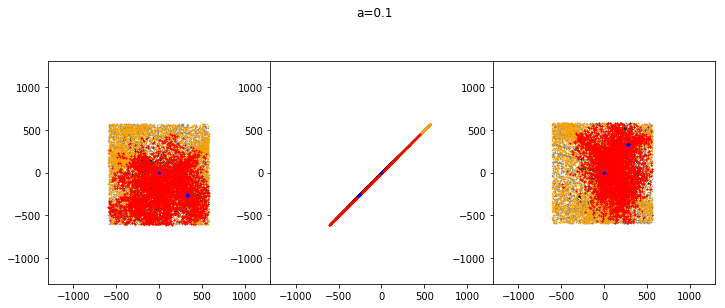

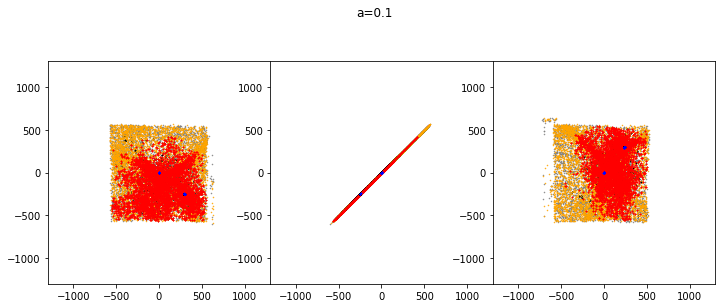

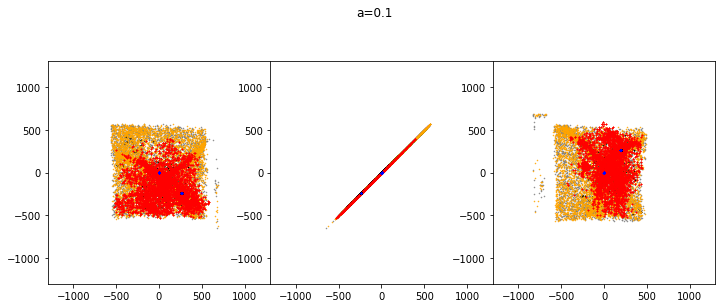

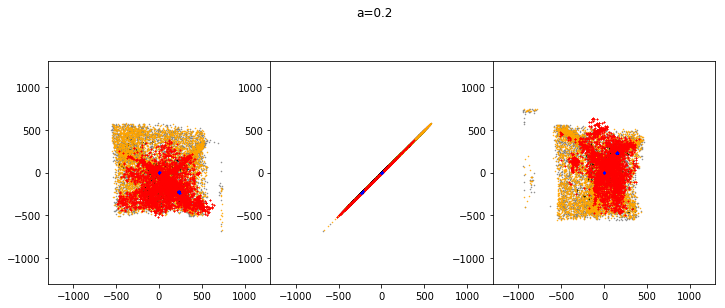

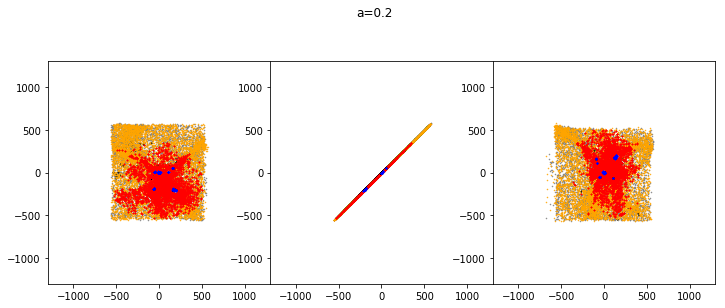

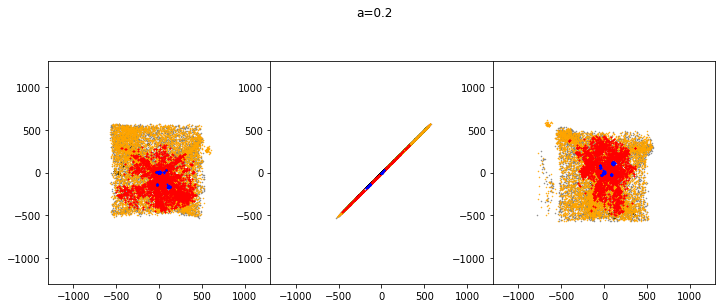

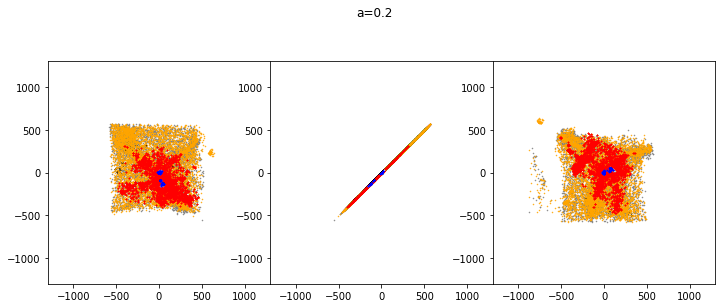

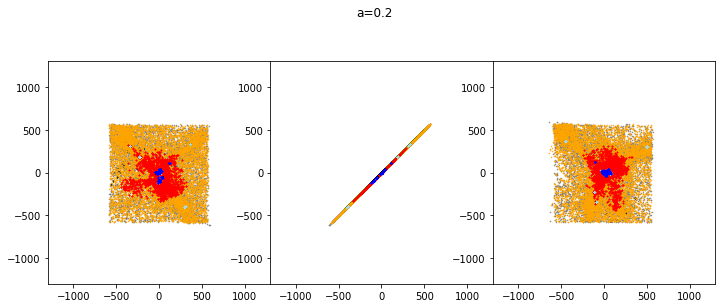

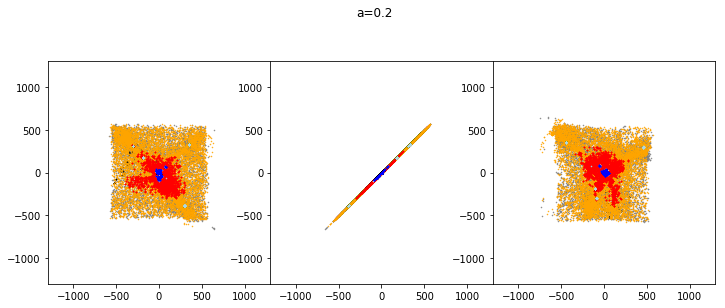

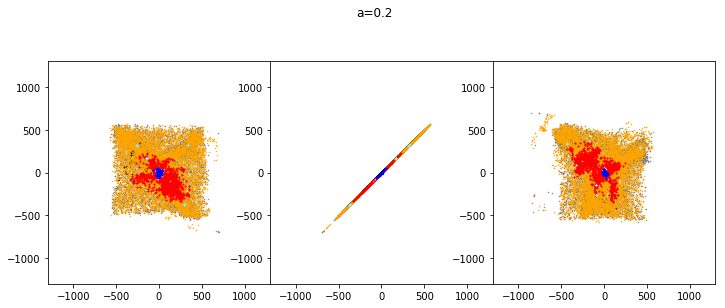

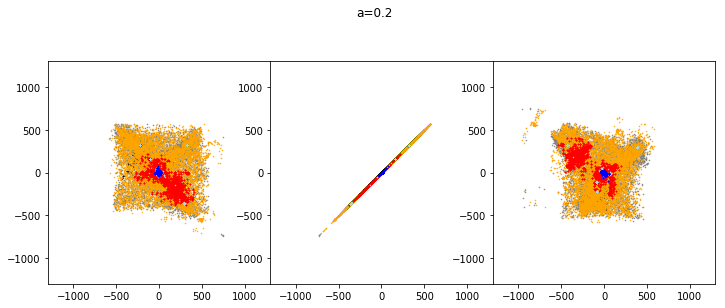

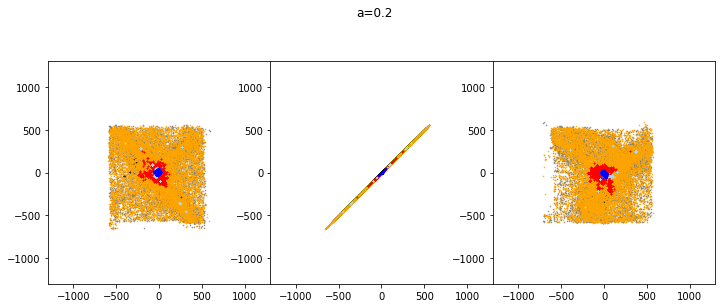

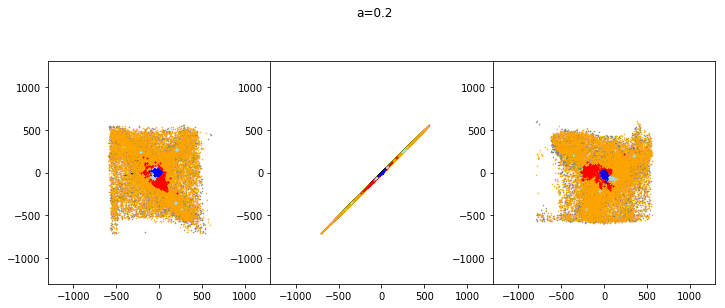

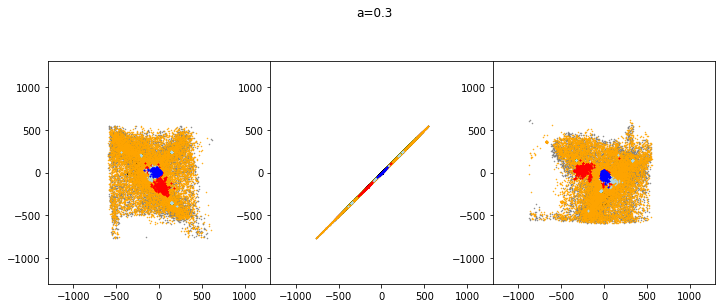

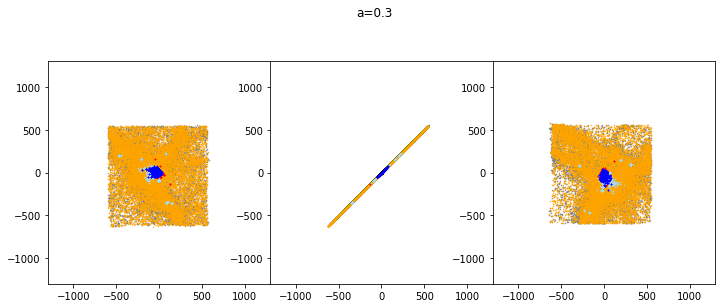

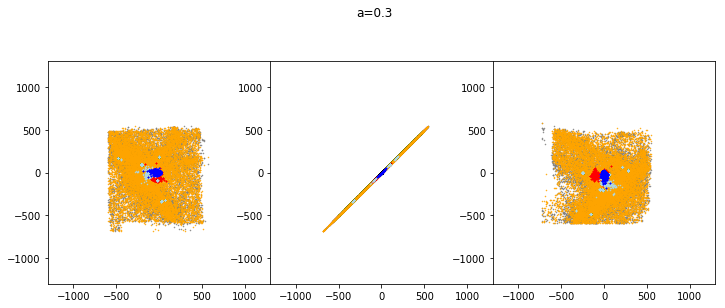

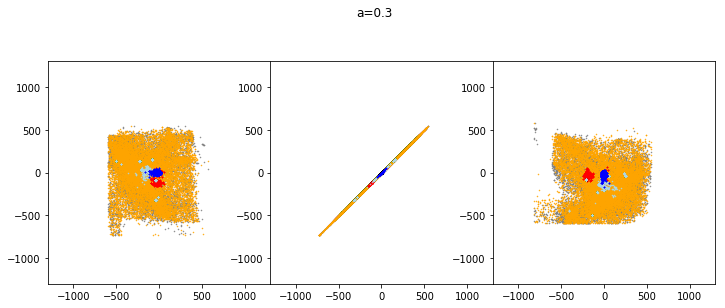

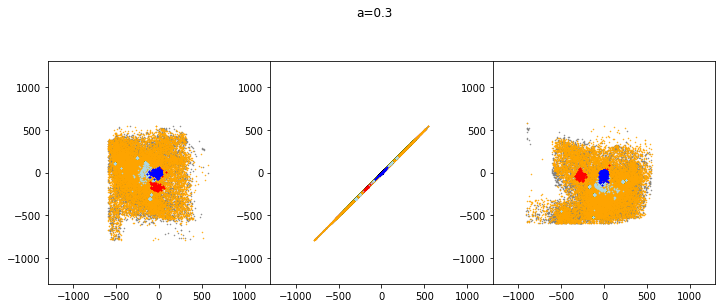

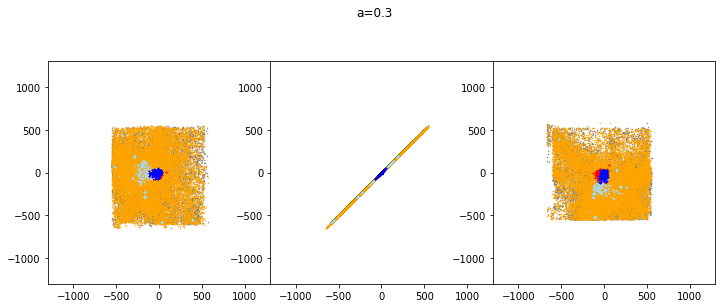

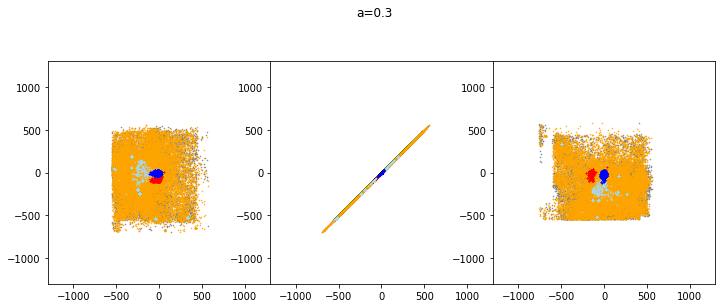

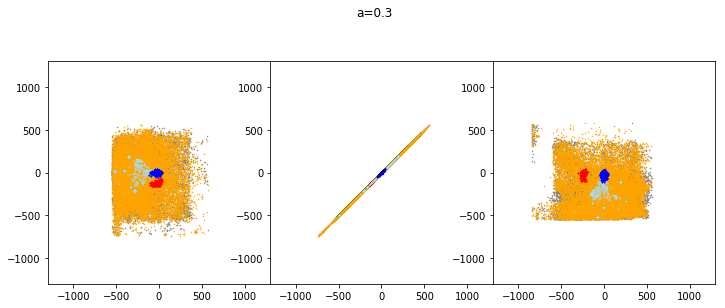

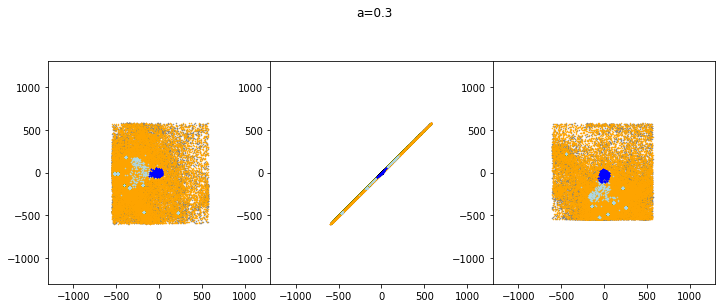

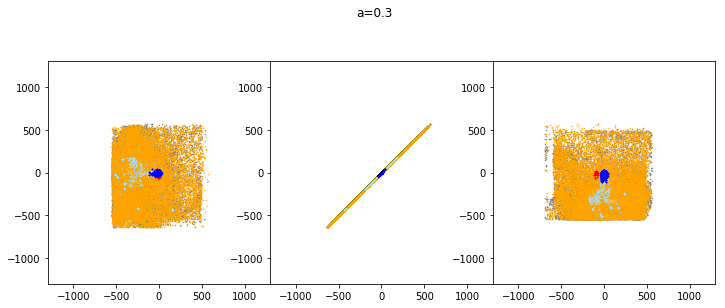

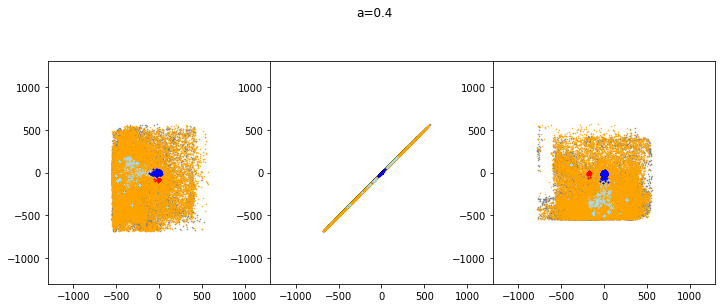

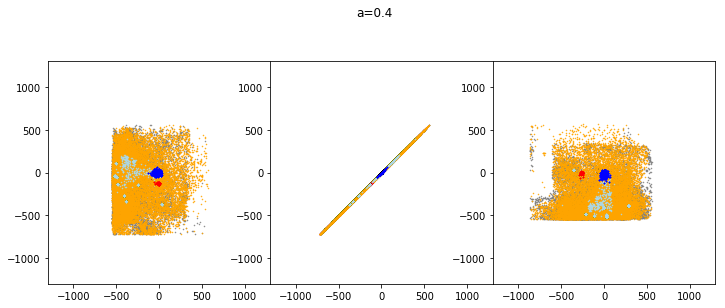

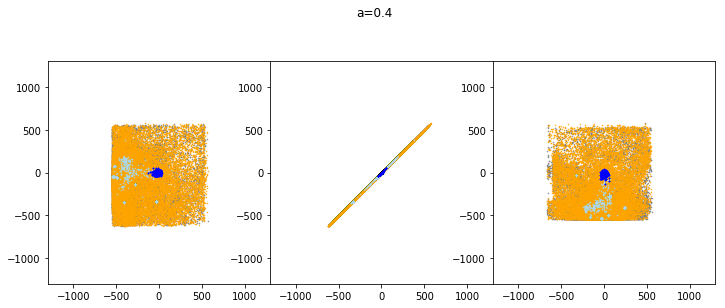

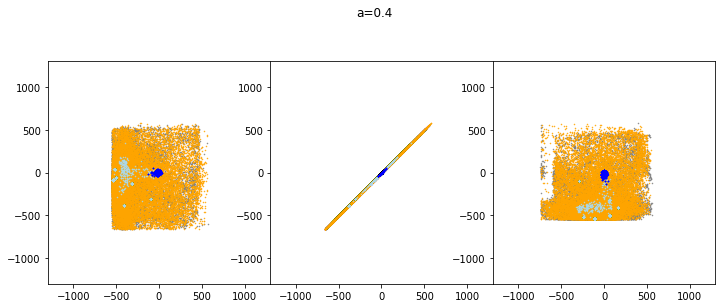

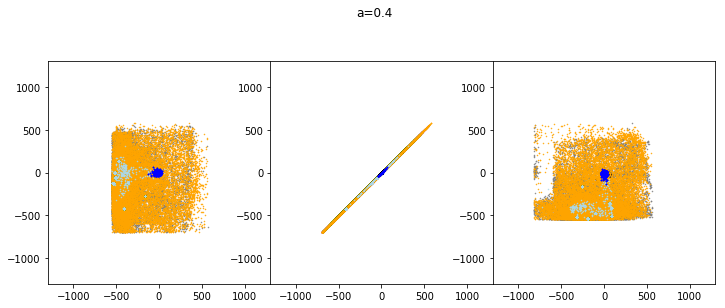

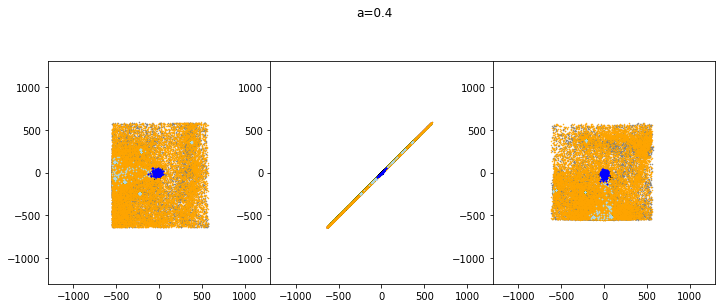

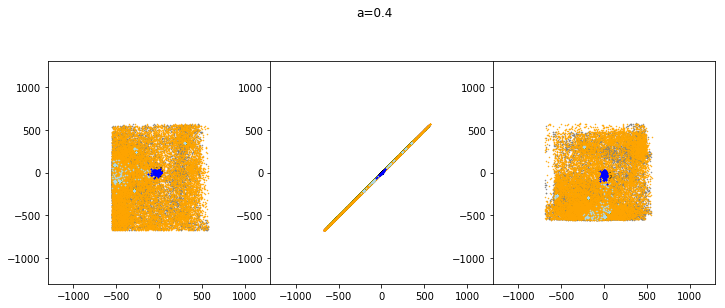

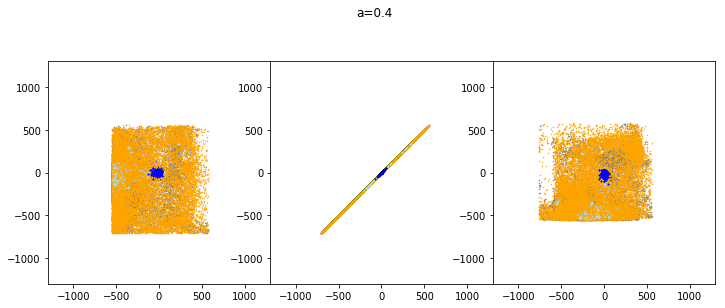

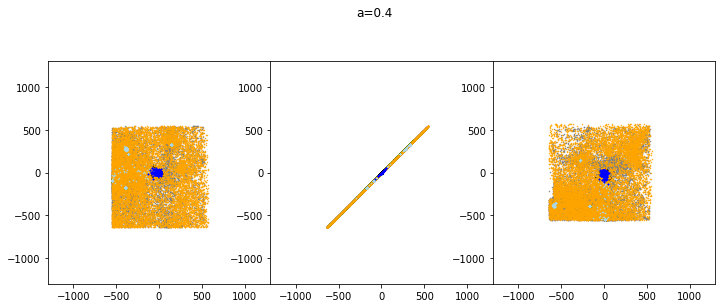

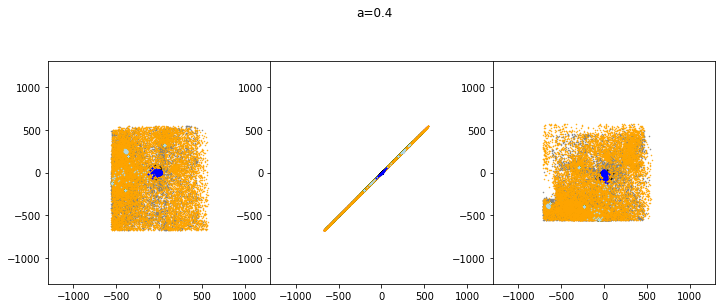

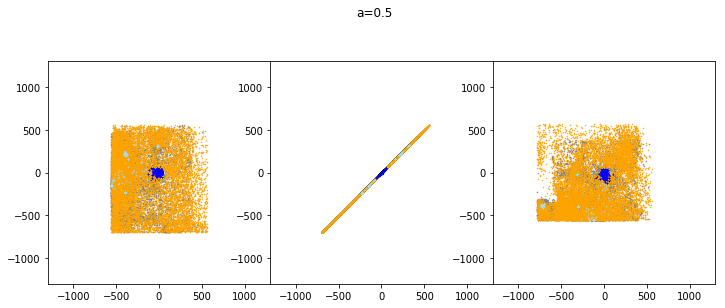

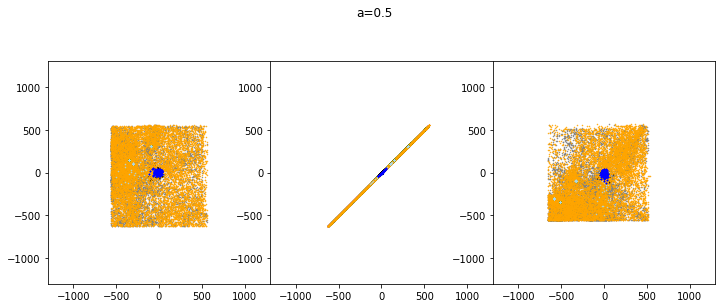

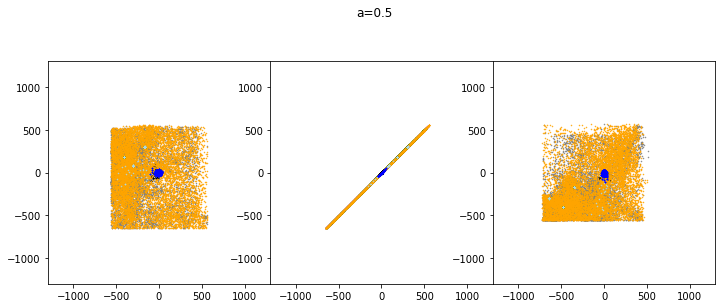

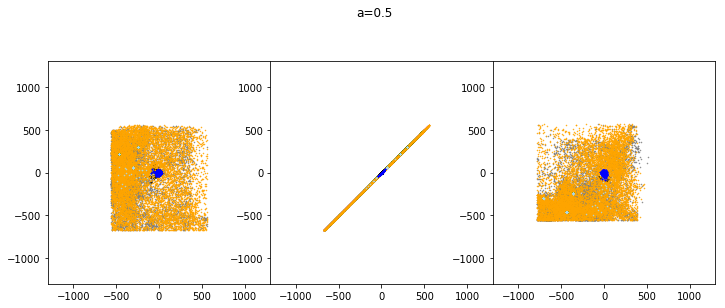

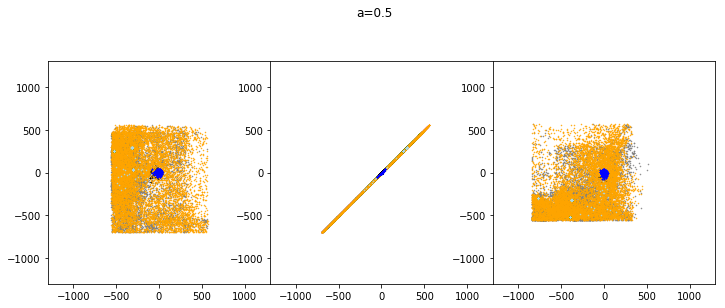

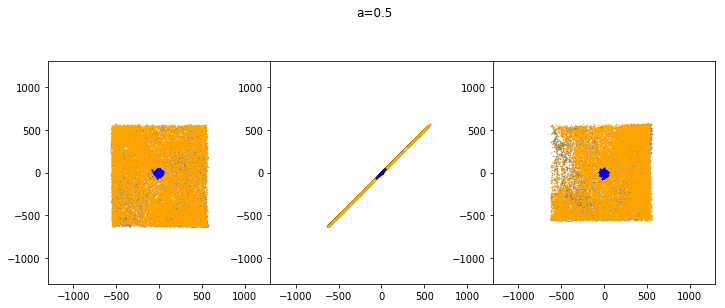

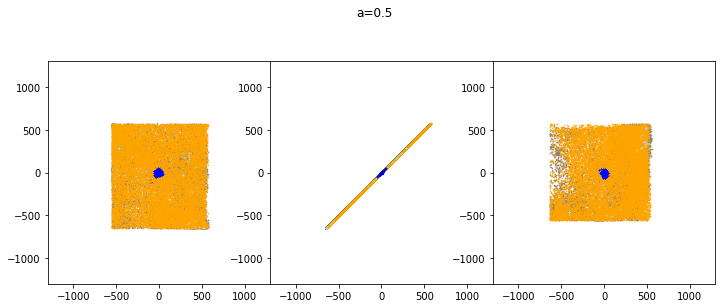

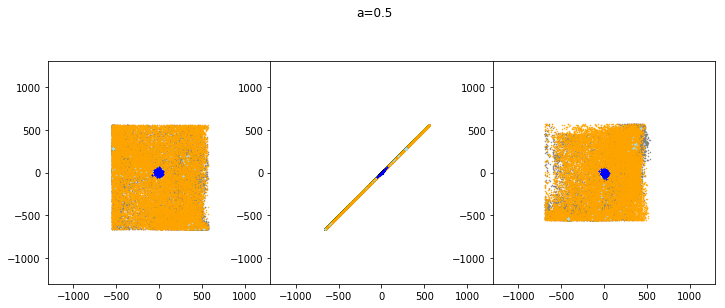

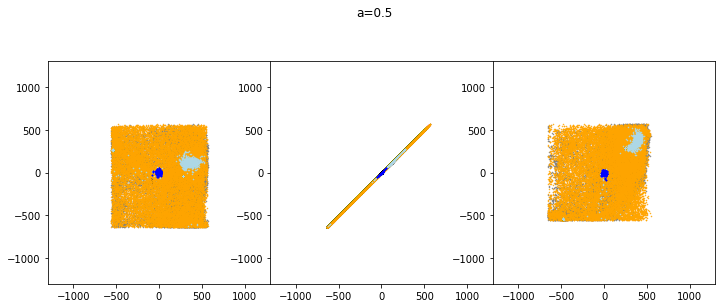

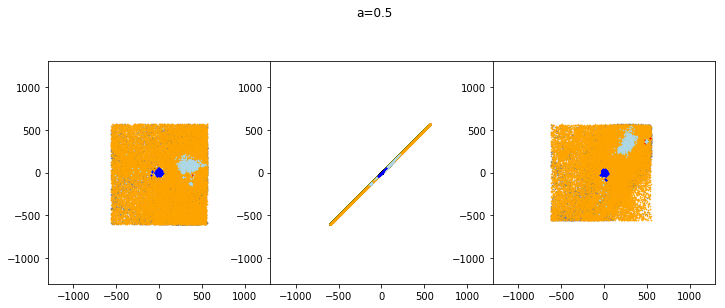

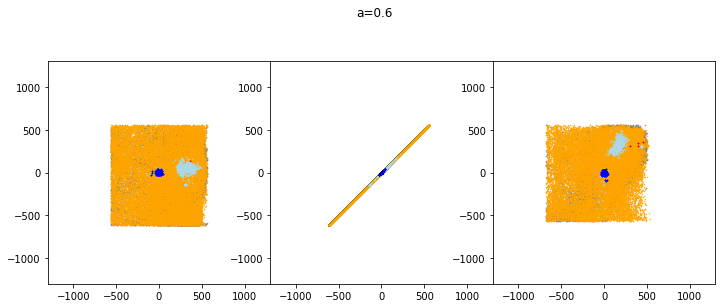

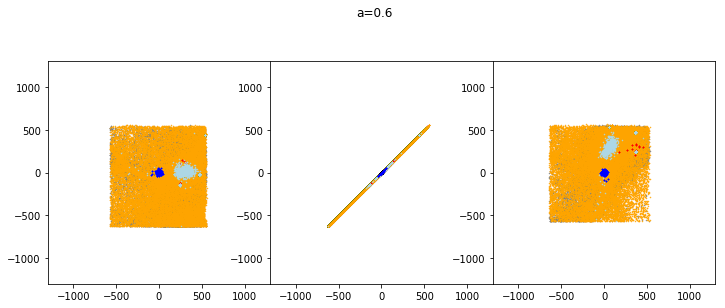

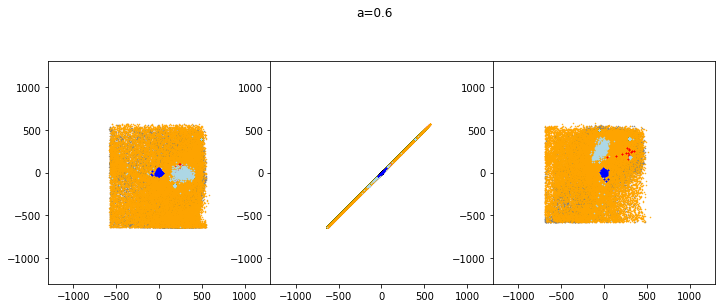

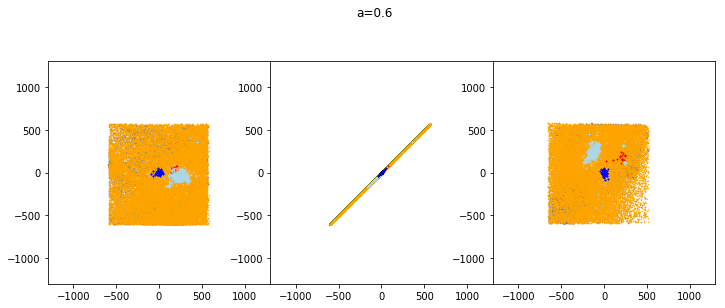

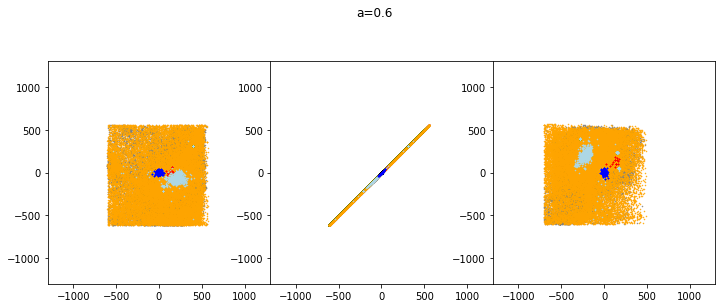

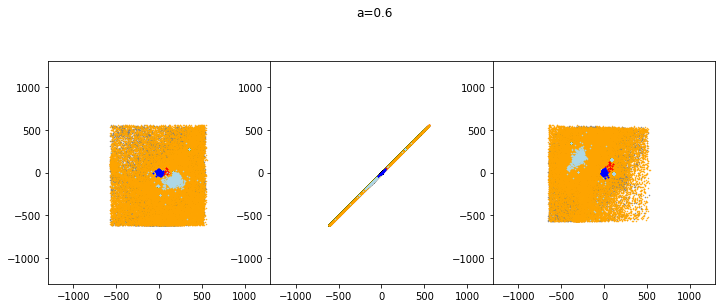

In [47]:
#key_frames.dataset.track_ids
#key_frames.dataset[ 0.2264175683051585][1]['MARK']
GUI(key_frames).matplotlib_3cameras_movie(0.01,'ciao.gif')

In [36]:
import pickle
save = pickle.load(open('save.p','rb'))

buckets = []
import pp

for s in save:
        buckets.append(pp.PostProcessing(**s))
        